In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import os

os.environ["HABNETIC_DATA"] = r"C:\Users\C.Price\Habnetic\data"


# Reproducibility
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

DATA_ROOT = os.environ.get("HABNETIC_DATA")
if DATA_ROOT is None:
    raise KeyError("HABNETIC_DATA not set. In PowerShell: $env:HABNETIC_DATA='C:\\Users\\C.Price\\Habnetic\\data'")

path = Path(DATA_ROOT) / "processed" / "RTM" / "priors" / "building_water_proximity.parquet"
print("Reading:", path)

df = pd.read_parquet(path)

# Use a manageable sample first
N = 2_000   # start small
df_s = df.sample(n=N, random_state=RANDOM_SEED).copy()

df_s.head(), df_s.shape


Reading: C:\Users\C.Price\Habnetic\data\processed\RTM\priors\building_water_proximity.parquet


(          building building:levels building:height height building:material  \
 120604         yes            None            None   None              None   
 68110          yes            None            None   None              None   
 90850        house            None            None   None              None   
 41071          yes            None            None   None              None   
 65852   apartments            None            None   None              None   
 
        roof:shape roof:material roof:height roof:levels  name addr:postcode  \
 120604       None          None        None        None  None          None   
 68110        None          None        None        None  None          None   
 90850        None          None        None        None  None          None   
 41071        None          None        None        None  None          None   
 65852        None          None        None        None  None          None   
 
         dist_to_water_m  water_len_

In [2]:
# Safer transforms
eps = 1e-9

# Distance (meters). +1 avoids log(0) and keeps interpretation sane.
df_s["x_d"] = np.log(df_s["dist_to_water_m"].clip(lower=0) + 1.0)

# Densities. Add eps to avoid log(0)
for r in [250, 500, 1000]:
    col = f"water_len_density_{r}m"
    df_s[f"x_{r}"] = np.log(df_s[col].clip(lower=0) + eps)

# Optional: standardize predictors so beta priors behave nicely
X_cols = ["x_d", "x_250", "x_500", "x_1000"]
X = df_s[X_cols].to_numpy()

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X_std[X_std == 0] = 1.0

Xz = (X - X_mean) / X_std

# Keep around for export / interpretation
df_s[["x_d", "x_250", "x_500", "x_1000"]] = Xz
df_s[X_cols].describe()


,x_d,x_250,x_500,x_1000
count,2.000000e+03,2.000000e+03,2.000000e+03,2.000000e+03
mean,-3.197442e-16,-1.243450e-17,-1.572076e-16,1.048051e-16
std,1.000250e+00,1.000250e+00,1.000250e+00,1.000250e+00
min,-5.308064e+00,-1.304572e+00,-2.432212e+00,-5.224757e+00
25%,-5.539104e-01,-1.304572e+00,1.419015e-01,-3.223405e-02
50%,2.844204e-02,6.082923e-01,3.884291e-01,2.455969e-01
75%,6.255376e-01,8.235404e-01,5.382715e-01,4.331332e-01
max,2.526510e+00,1.134076e+00,9.150321e-01,1.062949e+00


In [3]:
import pymc as pm
import arviz as az

coords = {"obs": np.arange(len(df_s)), "feature": X_cols}

X_data = df_s[X_cols].to_numpy()

with pm.Model(coords=coords) as model:
    X_pm = pm.MutableData("X", X_data, dims=("obs", "feature"))
    
    alpha = pm.Normal("alpha", mu=0.0, sigma=1.0)
    beta  = pm.Normal("beta",  mu=0.0, sigma=1.0, dims=("feature",))
    
    mu = pm.Deterministic("mu", alpha + pm.math.dot(X_pm, beta), dims=("obs",))
    
    # Identification / anchoring: fixed observation noise
    # This makes it a proper probabilistic regression-like scoring model.
    sigma = 1.0
    y = pm.Normal("E", mu=mu, sigma=sigma, observed=np.zeros(len(df_s)), dims=("obs",))
    
    idata = pm.sample(
        draws=500,
        tune=500,
        chains=2,
        cores=2,
        target_accept=0.9,
        random_seed=RANDOM_SEED
    )


az.summary(idata, var_names=["alpha", "beta"])


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 378 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.023,-0.036,0.049,0.001,0.001,688.0,677.0,1.0
beta[x_d],-0.000,0.040,-0.070,0.079,0.002,0.001,588.0,511.0,1.0
beta[x_250],0.001,0.037,-0.065,0.071,0.002,0.001,463.0,663.0,1.0
beta[x_500],-0.001,0.035,-0.062,0.069,0.001,0.001,697.0,529.0,1.0
beta[x_1000],0.000,0.030,-0.058,0.057,0.001,0.001,719.0,653.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x_d,-0.000,0.040,-0.070,0.079,0.002,0.001,588.0,511.0,1.0
x_250,0.001,0.037,-0.065,0.071,0.002,0.001,463.0,663.0,1.0
x_500,-0.001,0.035,-0.062,0.069,0.001,0.001,697.0,529.0,1.0
x_1000,0.000,0.030,-0.058,0.057,0.001,0.001,719.0,653.0,1.0


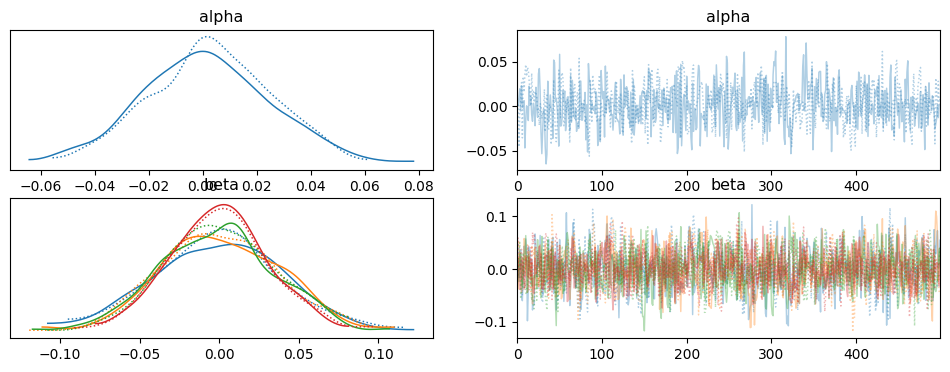

In [4]:
az.plot_trace(idata, var_names=["alpha", "beta"]);

beta_post = az.summary(idata, var_names=["beta"])
beta_post.index = X_cols
beta_post


In [5]:
# posterior for mu: shape (chain, draw, obs)
mu_post = idata.posterior["mu"]

mu_mean = mu_post.mean(dim=("chain", "draw")).to_numpy()
mu_sd   = mu_post.std(dim=("chain", "draw")).to_numpy()

out = pd.DataFrame({
    "fid": df_s["fid"].to_numpy() if "fid" in df_s.columns else df_s.index.to_numpy(),
    "E_hat": mu_mean,
    "E_sd": mu_sd,
})

# Persist
out_dir = Path("outputs") / "rtm"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "water_exposure_latent_v0_sample20k.parquet"
out.to_parquet(out_path, index=False)

out_path, out.describe()


(WindowsPath('outputs/rtm/water_exposure_latent_v0_sample20k.parquet'),
                  fid        E_hat         E_sd
 count    2000.000000  2000.000000  2000.000000
 mean   112508.481000     0.002160     0.046548
 std     64081.753609     0.000761     0.020533
 min        34.000000     0.000714     0.025186
 25%     57327.250000     0.001620     0.033551
 50%    113432.000000     0.002383     0.039659
 75%    169083.500000     0.002675     0.051111
 max    221216.000000     0.004683     0.181356)